In [111]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import Laguerre_Gaussian as LG
import phaseScreenGeneration as PS

N = 512
L = 1
ql = 2
zi = 0
zf = 100000
wvl = 500e-9
wr = 0.13
wvn = 2*np.pi/wvl
dx = L/N
dz = 1000

In [112]:
def UGen(waistRatio, wavelength, zInital, nPix, frameSize, quantumL):
    waveNumber = 2*np.pi/wvl
    rayleighRange0 = LG.zR(waistRatio, wavelength)
    spotSizeParam0 = LG.wZ(waistRatio, zInital, rayleighRange0)
    ui = np.zeros((nPix,nPix), dtype = 'complex128')
    Dist = LG.distances(nPix, frameSize/nPix)
    Angl = LG.angles(nPix)
    for i in range(0, nPix):
        for j in range(0, nPix):
            ui[i,j] = LG.Ulp(Dist[i,j], zInital,  quantumL, 0, spotSizeParam0, waveNumber, rayleighRange0, Angl[i,j])
    return ui

In [113]:
def waveMerge(u1, u2):
    I = np.abs(u1 + u2) ** 2
    return I

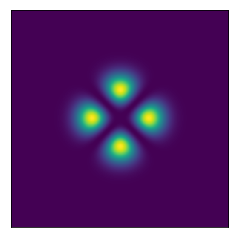

In [114]:
uPlus0 = UGen(wr, wvl, zi, N, L, ql)
uMinus0 = UGen(wr, wvl, zi, N, L, -ql)
I0 = waveMerge(uPlus0, uMinus0)
LG.CMgraph(I0)

In [9]:
def halfProp(Uin, phaseScreen):
    UPhased = Uin * np.exp(1j*phaseScreen)
    Ukspace = np.fft.fft2(np.fft.fftshift(UPhased))
    return np.fft.fftshift(Ukspace)
def halfProp2(Ukspace, propagationDistance, specialK):
    Ukpropagated = Ukspace*np.exp(1j*propagationDistance*specialK)
    Uxspace = np.fft.ifft2(np.fft.ifftshift(Ukpropagated))
    return np.fft.ifftshift(Uxspace)
def propagation(Uin, phaseScreen, propagationDistance, specialK):
    Uworking = halfProp(Uin, phaseScreen)
    Uworking = halfProp2(Uworking, propagationDistance, specialK)
    return Uworking

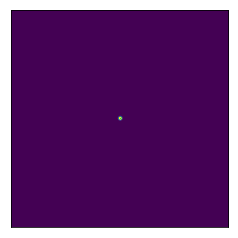

In [10]:
LG.CMgraph( np.abs(halfProp(uPlus0,np.zeros((N,N)))*np.exp(1j*1/(dz*wvn))) )

In [11]:
print(np.exp(1j*(dz*wvn)))

(0.9999999999984255+1.7745429811534507e-06j)


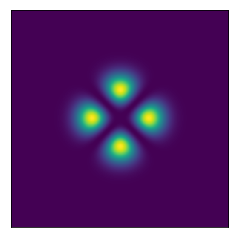

In [12]:
LG.CMgraph( waveMerge(propagation(uPlus0,np.zeros((N,N)),1/dz, wvn),propagation(uMinus0,np.zeros((N,N)),1/dz, wvn)))

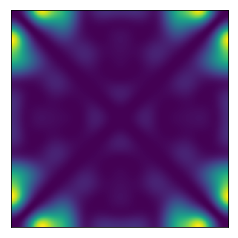

In [13]:
kGrid = PS.scalrFGrid(N, N/L)
LG.CMgraph( waveMerge(propagation(uPlus0,np.zeros((N,N)),dz, kGrid),propagation(uMinus0,np.zeros((N,N)),dz, kGrid)))

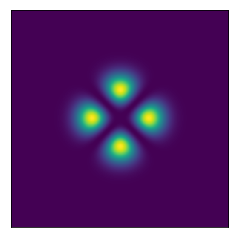

In [34]:
for i in range(0, 10):
    uPlus = propagation(uPlus0,np.zeros((N,N)),dz, wvn)
    uMinus = propagation(uMinus0,np.zeros((N,N)),dz, wvn)
LG.CMgraph(waveMerge(uPlus, uMinus))

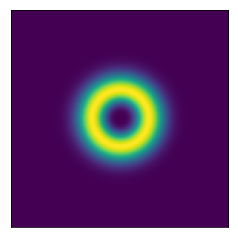

In [15]:
LG.CMgraph(waveMerge(uPlus - uPlus0, uMinus - uMinus))

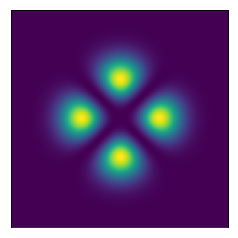

In [33]:
uPlusZF = UGen(wr, wvl, zf, N, L, ql)
uMinusZF = UGen(wr, wvl, zf, N, L, -ql)
IZF = waveMerge(uPlusZF, uMinusZF)
LG.CMgraph(IZF)

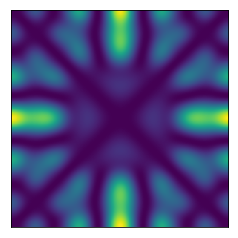

In [108]:
def scalrZFGrid(N, dF, waveN):
    fr = np.arange(-N/2.0, N/2.0) * dF
    fx, fy = np.meshgrid(fr, -1*fr)
    #fz = 1/dz * dF
    f = np.sqrt((waveN**2) - (fx**2) - (fy**2))
    return f

uPlus = uPlus0
uMinus = uMinus0
for i in range(0, 100):
    uPlus = propagation(uPlus, np.zeros((N,N)), dz, scalrZFGrid(N, 2*np.pi/dx, wvn))
    uMinus = propagation(uMinus, np.zeros((N,N)), dz, scalrZFGrid(N, 2*np.pi/dx, wvn))
LG.CMgraph(  (waveMerge(uPlus, uMinus)))

In [77]:
def propturbulence(z, U, N, L, screen, waveN, r0 = 0):
    #S = phasescreen(N, L, r0)
    T = L/N
    fval = np.fft.fftn(U * np.exp(1j*screen))*T**2
    xf = np.fft.fftfreq(N,T)
    xf = np.fft.fftshift(xf)
    yf = np.fft.fftfreq(N,T)
    yf = np.fft.fftshift(yf)
    fval = np.fft.fftshift(fval)
    fval2 = fval.copy()
    for i in range(N):
        for j in range(N):
            fval2[i,j] = np.exp(1j*(waveN**2 - (xf[j]*2*np.pi)**2 - (yf[i]*2*np.pi)**2)**0.5 * z) * fval2[i,j]
    fval2 = np.fft.fftshift(fval2)
    dirval2 = np.fft.ifftn(fval2)/T**2
    return dirval2

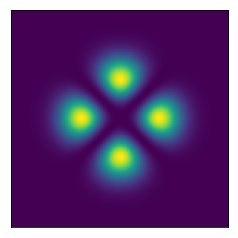

In [109]:
uPlusP1000 = uPlus0
uMinusP1000 = uMinus0
for i in range(0, 100):
    uPlusP1000 = propturbulence(1000, uPlusP1000, N, 1, np.zeros((N,N)), wvn)
    uMinusP1000 =  propturbulence(1000, uMinusP1000, N, 1, np.zeros((N,N)), wvn)

LG.CMgraph( waveMerge(uPlusP, uMinusP))

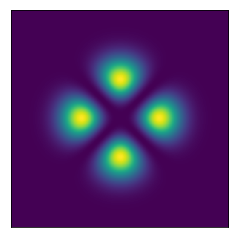

In [98]:
uPlusP100 = uPlus0
uMinusP100 = uMinus0
for i in range(0, 1000):
    uPlusP100 = propturbulence(100, uPlusP100, N, 1, np.zeros((N,N)), wvn)
    uMinusP100 =  propturbulence(100, uMinusP100, N, 1, np.zeros((N,N)), wvn)
#This took far too long to be practical
LG.CMgraph( waveMerge(uPlusP100, uMinusP100)) 

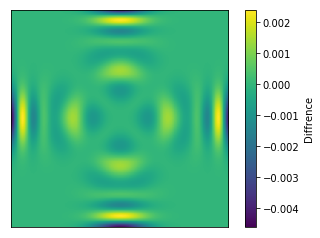

In [110]:
LG.CMgraphBar( IZF - waveMerge(uPlusP1000, uMinusP1000), "Diffrence")

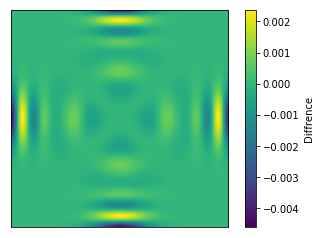

In [103]:
LG.CMgraphBar( IZF - waveMerge(uPlusP100, uMinusP100), "Diffrence")